# ESP32 + LD2410: TensorFlow Linear model for classification of movements
### Подготовил: Степанюк Денис Борисович

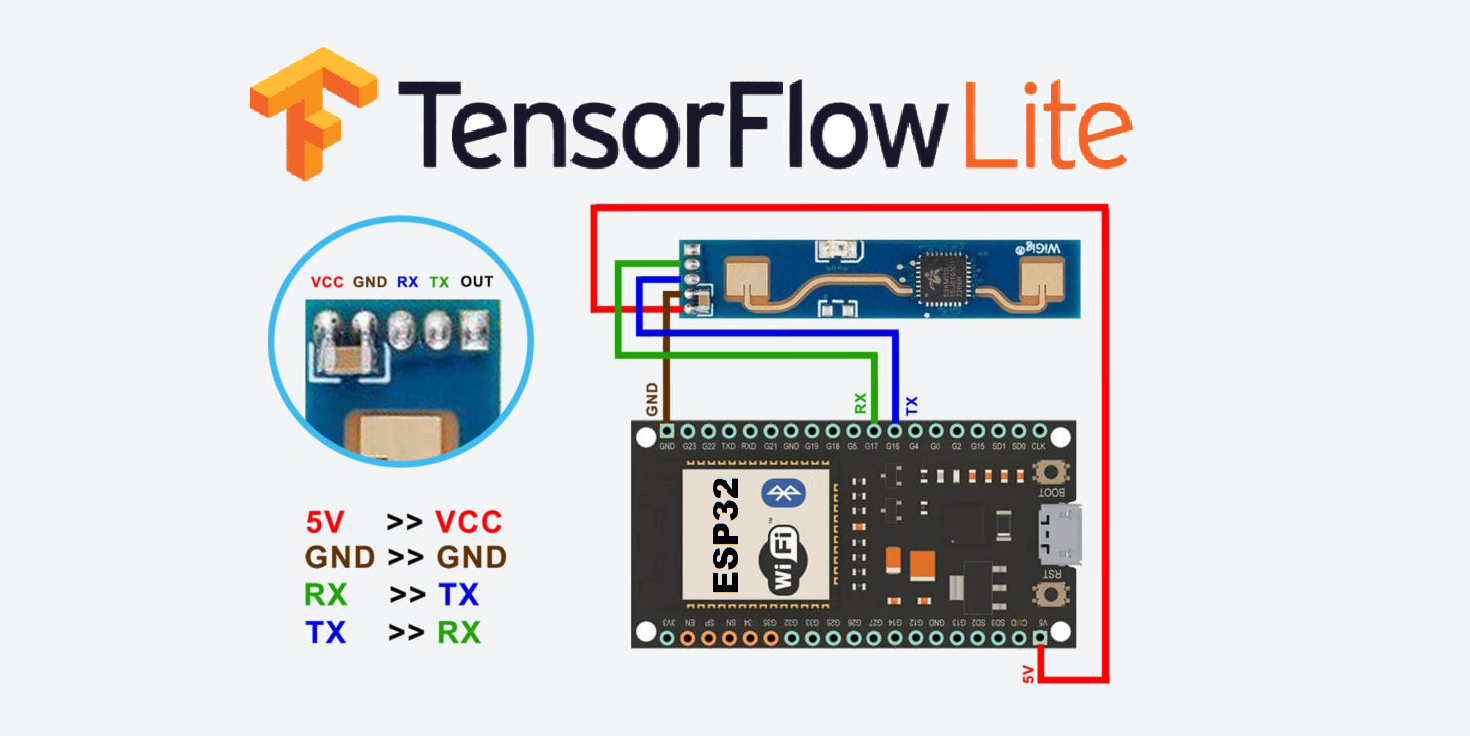
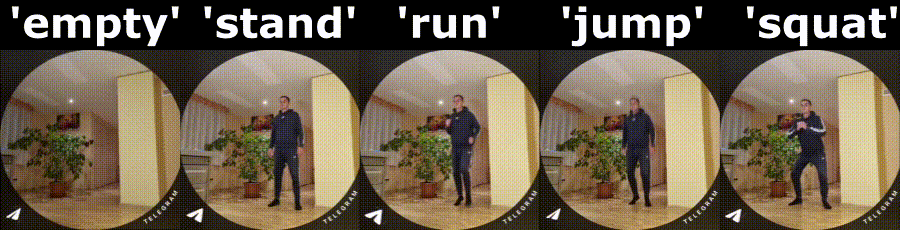

### Структура датафрейма

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Столбцы числовых признаков.
num_cols = [
    ' MOVE_1',
    ' MOVE_2',
    ' MOVE_3',
    ' MOVE_4',
    ' MOVE_5',
    ' MOVE_6',
    ' MOVE_7',
    ' MOVE_8',
    ' MOVE_9',
    ' STAT_1',
    ' STAT_2',
    ' STAT_3',
    ' STAT_4',
    ' STAT_5',
    ' STAT_6',
    ' STAT_7',
    ' STAT_8',
    ' STAT_9'
]

# Столбец предсказываемого категориального признака.
target_col = 'CATEGORY'

# Предсказываемые категории.
categories = ['empty', 'stand', 'run', 'jump', 'squat']

# Кол-во предсказываемых категорий.
cat_num = len(categories)

# Загрузка данных

In [2]:
import os

# путь к папке
folder_path = './Dataset'

# собираем список всех CSV файлов
files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# читаем все CSV и складываем в список
dataframes = [pd.read_csv(os.path.join(folder_path, f)) for f in files]

# объединяем в один DataFrame
data_all = pd.concat(dataframes, ignore_index=True)

data_all.head()

CATEGORY   MOVE_1   MOVE_2   MOVE_3   MOVE_4   MOVE_5   MOVE_6   MOVE_7  \
0    stand       33       26       43       37       11        4        8   
1    stand       31       23       58       51        6       10        6   
2    stand       34       27       57       45        4        7       10   
3    stand       39       28       10       16       15       12        5   
4    stand       38       33       48       22       20       11       10   

    MOVE_8   MOVE_9  ...   STAT_2   STAT_3   STAT_4   STAT_5   STAT_6  \
0        6        4  ...        0      100      100      100       73   
1        8        4  ...        0      100      100      100       69   
2       12       10  ...        0      100      100      100       66   
3        4        9  ...        0      100      100      100       62   
4        4        4  ...        0      100      100      100       70   

    STAT_7   STAT_8   STAT_9    TIME   ID   
0       55       38       25  792656     1  
1       88      100      100  594766     2  
2       63       87       75  595823     3  
3       60       84       65  596919     4  
4       64       80       58  597979     5  

[5 rows x 21 columns]

# Визуализация данных
### График изменения состояния гейтов во времени

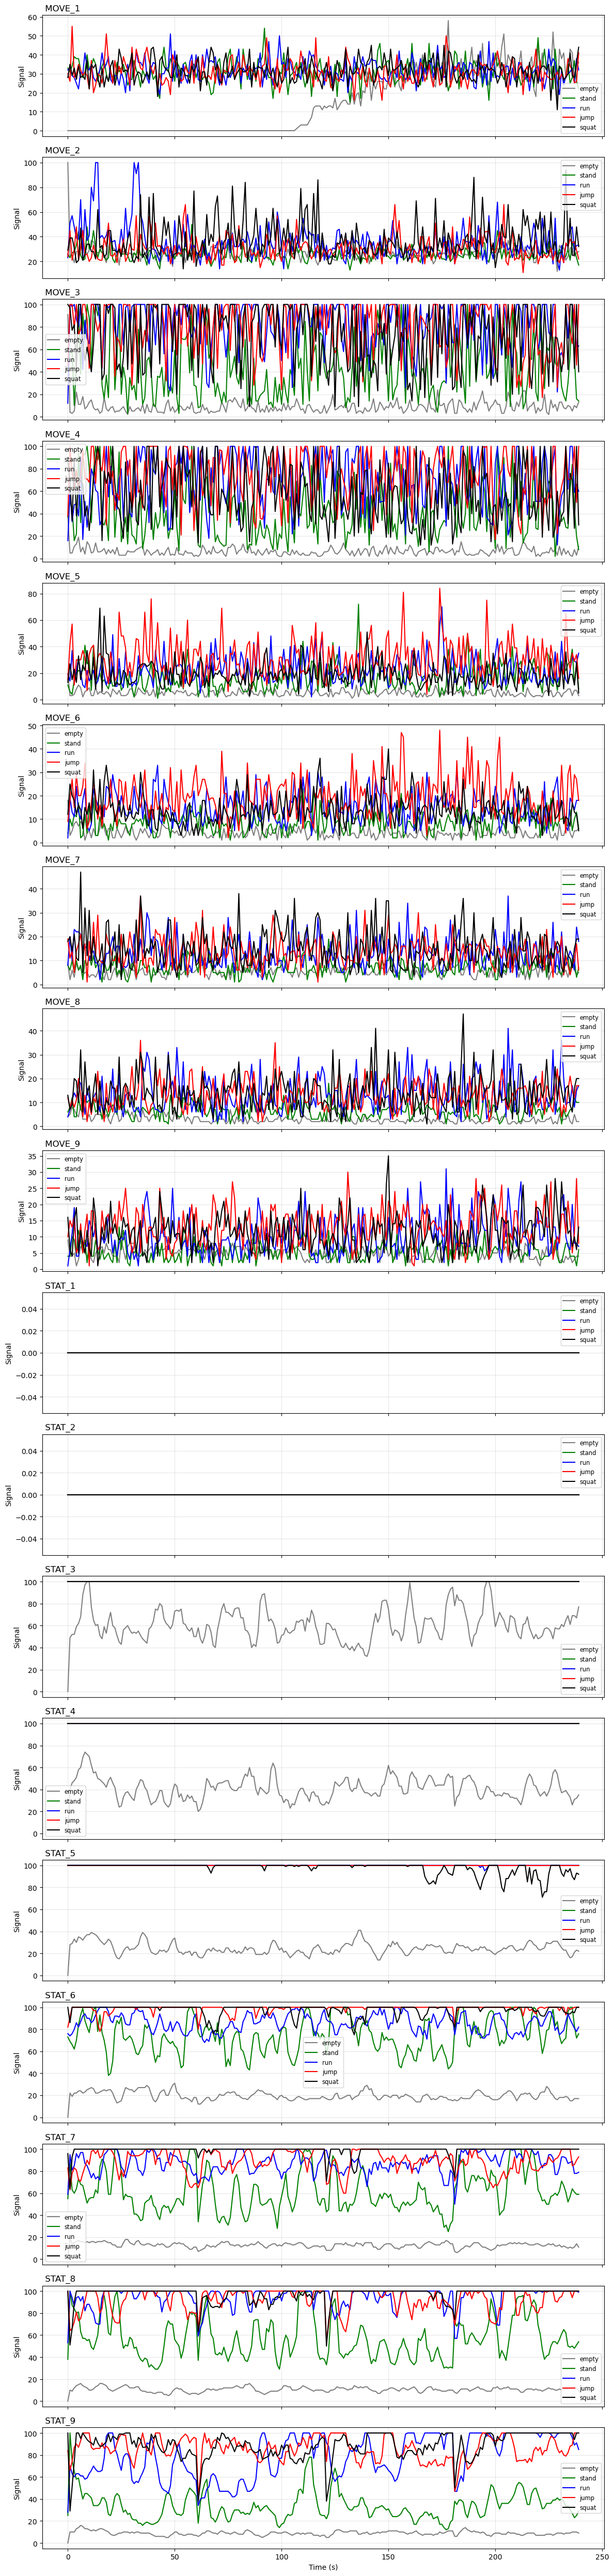

In [3]:
# Цвета для категорий (5 категорий = 5 цветов)
colors = ['gray', 'green', 'blue', 'red', 'black']

# 18 осей (по числу столбцов в num_cols)
fig, ax_list = plt.subplots(18, 1, figsize=(12, 50), sharex=True)

# Если ax_list одномерный массив — итерируемся по нему напрямую
for column, ax in zip(num_cols, ax_list):
    for color, cat in zip(colors, categories):
        # Берём первые 60 наблюдений для категории
        series = (data_all.loc[data_all['CATEGORY'] == cat, column]
                          .dropna()
                          .head(240))
        if series.empty:
            continue

        # Временная ось: по секундам (0..n-1)
        x = np.arange(len(series))
        ax.plot(x, series.values, label=cat, color=color)

    ax.set_title(column, loc='left')
    ax.set_ylabel('Signal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize='small')

# Общая подпись оси X только внизу
ax_list[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Подготовка данных
### Делим набор данных на тренировочный и валидационный

In [4]:
# Список для набора тренировочных данных.
train_dataframe = []
# Список для набора валидационных данных.
test_dataframe = []

# Итерируемся по предсказываемым категорияим.
for c in categories:
    # Добавлеяи в набор тренировочных данных экземпляры данных для текущей категории (все кроме 50 последних).
    train_dataframe.append(data_all[data_all['CATEGORY'] == c][[target_col] + num_cols][:-50])
    # Добавлеяи в набор валидационных данных экземпляры данных для текущей категории (50 последних экземпляров).
    test_dataframe.append(data_all[data_all['CATEGORY'] == c][[target_col] + num_cols][-50:])

# Преобразуем списки в датафреймы.
train_dataframe = pd.concat(train_dataframe, ignore_index=True)
test_dataframe = pd.concat(test_dataframe, ignore_index=True)

### Формируем из данных входы для модели

In [5]:
# Кол-во экземпляров данных формирующих один батч.
step = 10

# Набор тренировочных данных.
X_train = []
# Набор предсказываемых категорий для тренировочных данных.
Y_train_labels = []

# Набор валидационных данных.
X_test = []
# Набор предсказываемых категорий для валидационных данных.
Y_test_labels = []

# Итерируемся по предсказываемым категорияим.
for c in categories:
    # Кол-во экземпляров данных в тренировочном наборе.
    category_train_len = len(train_dataframe[train_dataframe['CATEGORY'] == c])
    # Получим массив входов (единичных батчей 10х18) для тренировочного набора данных.
    for i in range(category_train_len):
        if(i + step < category_train_len):
            Y_train_labels.append(c)
            X_train.append(train_dataframe[train_dataframe['CATEGORY'] == c][num_cols][i:i+step].to_numpy())
        else:
            continue
    # Кол-во экземпляров данных в валидационном наборе.
    category_test_len = len(test_dataframe[test_dataframe['CATEGORY'] == c])
    # Получим массив входов (единичных батчей 10х18) для валидационного набора данных.
    for i in range(category_test_len):
        if(i + step < category_test_len):
            Y_test_labels.append(c)
            X_test.append(test_dataframe[test_dataframe['CATEGORY'] == c][num_cols][i:i+step].to_numpy())
        else:
            continue

# Набор тренировочных данных.
X_train = np.array(X_train)
# Преобразуем (конкатенируем) прямоугольные матрицы 10х18 в вектора размерности 180 для линейной модели.
X_train = X_train.reshape(X_train.shape[0], -1)
# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_train = pd.get_dummies(Y_train_labels)

# Набор валидационных данных.
X_test = np.array(X_test)
# Преобразуем (конкатенируем) прямоугольные матрицы 10х18 в вектора размерности 180 для линейной модели.
X_test = X_test.reshape(X_test.shape[0], -1)
# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_test = pd.get_dummies(Y_test_labels)

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(900, 180)
(900, 5)
(200, 180)
(200, 5)


### Рандомно перемешаем тренировочные данные

In [7]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части.
X1, X2, Y1, Y2 = train_test_split(X_train, Y_train, train_size = 0.5)

# Обьеденим две части датасета.
X_train = np.concatenate((X1, X2), axis=0)
Y_train = np.concatenate((Y1, Y2), axis=0)

In [8]:
print(X_train.shape)
print(Y_train.shape)

(900, 180)
(900, 5)


# ЛИНЕЙНЫЕ МОДЕЛИ

**Линейная модель — это математическая модель, которая строит предсказания на основе линейной комбинации входных признаков. Она особенно часто используется для решения задач классификации и регрессии.**

* **Каждому признаку входных данных назначается вес (коэффициент), который показывает его важность.**

* **Модель вычисляет взвешенную сумму признаков и добавляет смещение (bias), формируя итоговое значение.**

* **В задаче классификации это значение передаётся через функцию активации (например, сигмоиду или softmax), которая преобразует его в вероятность принадлежности объекта к определённому классу.**

* **Таким образом, линейная модель фактически ищет гиперплоскость, которая разделяет данные на два или более классов. Чем лучше подобраны веса, тем точнее разделение.**
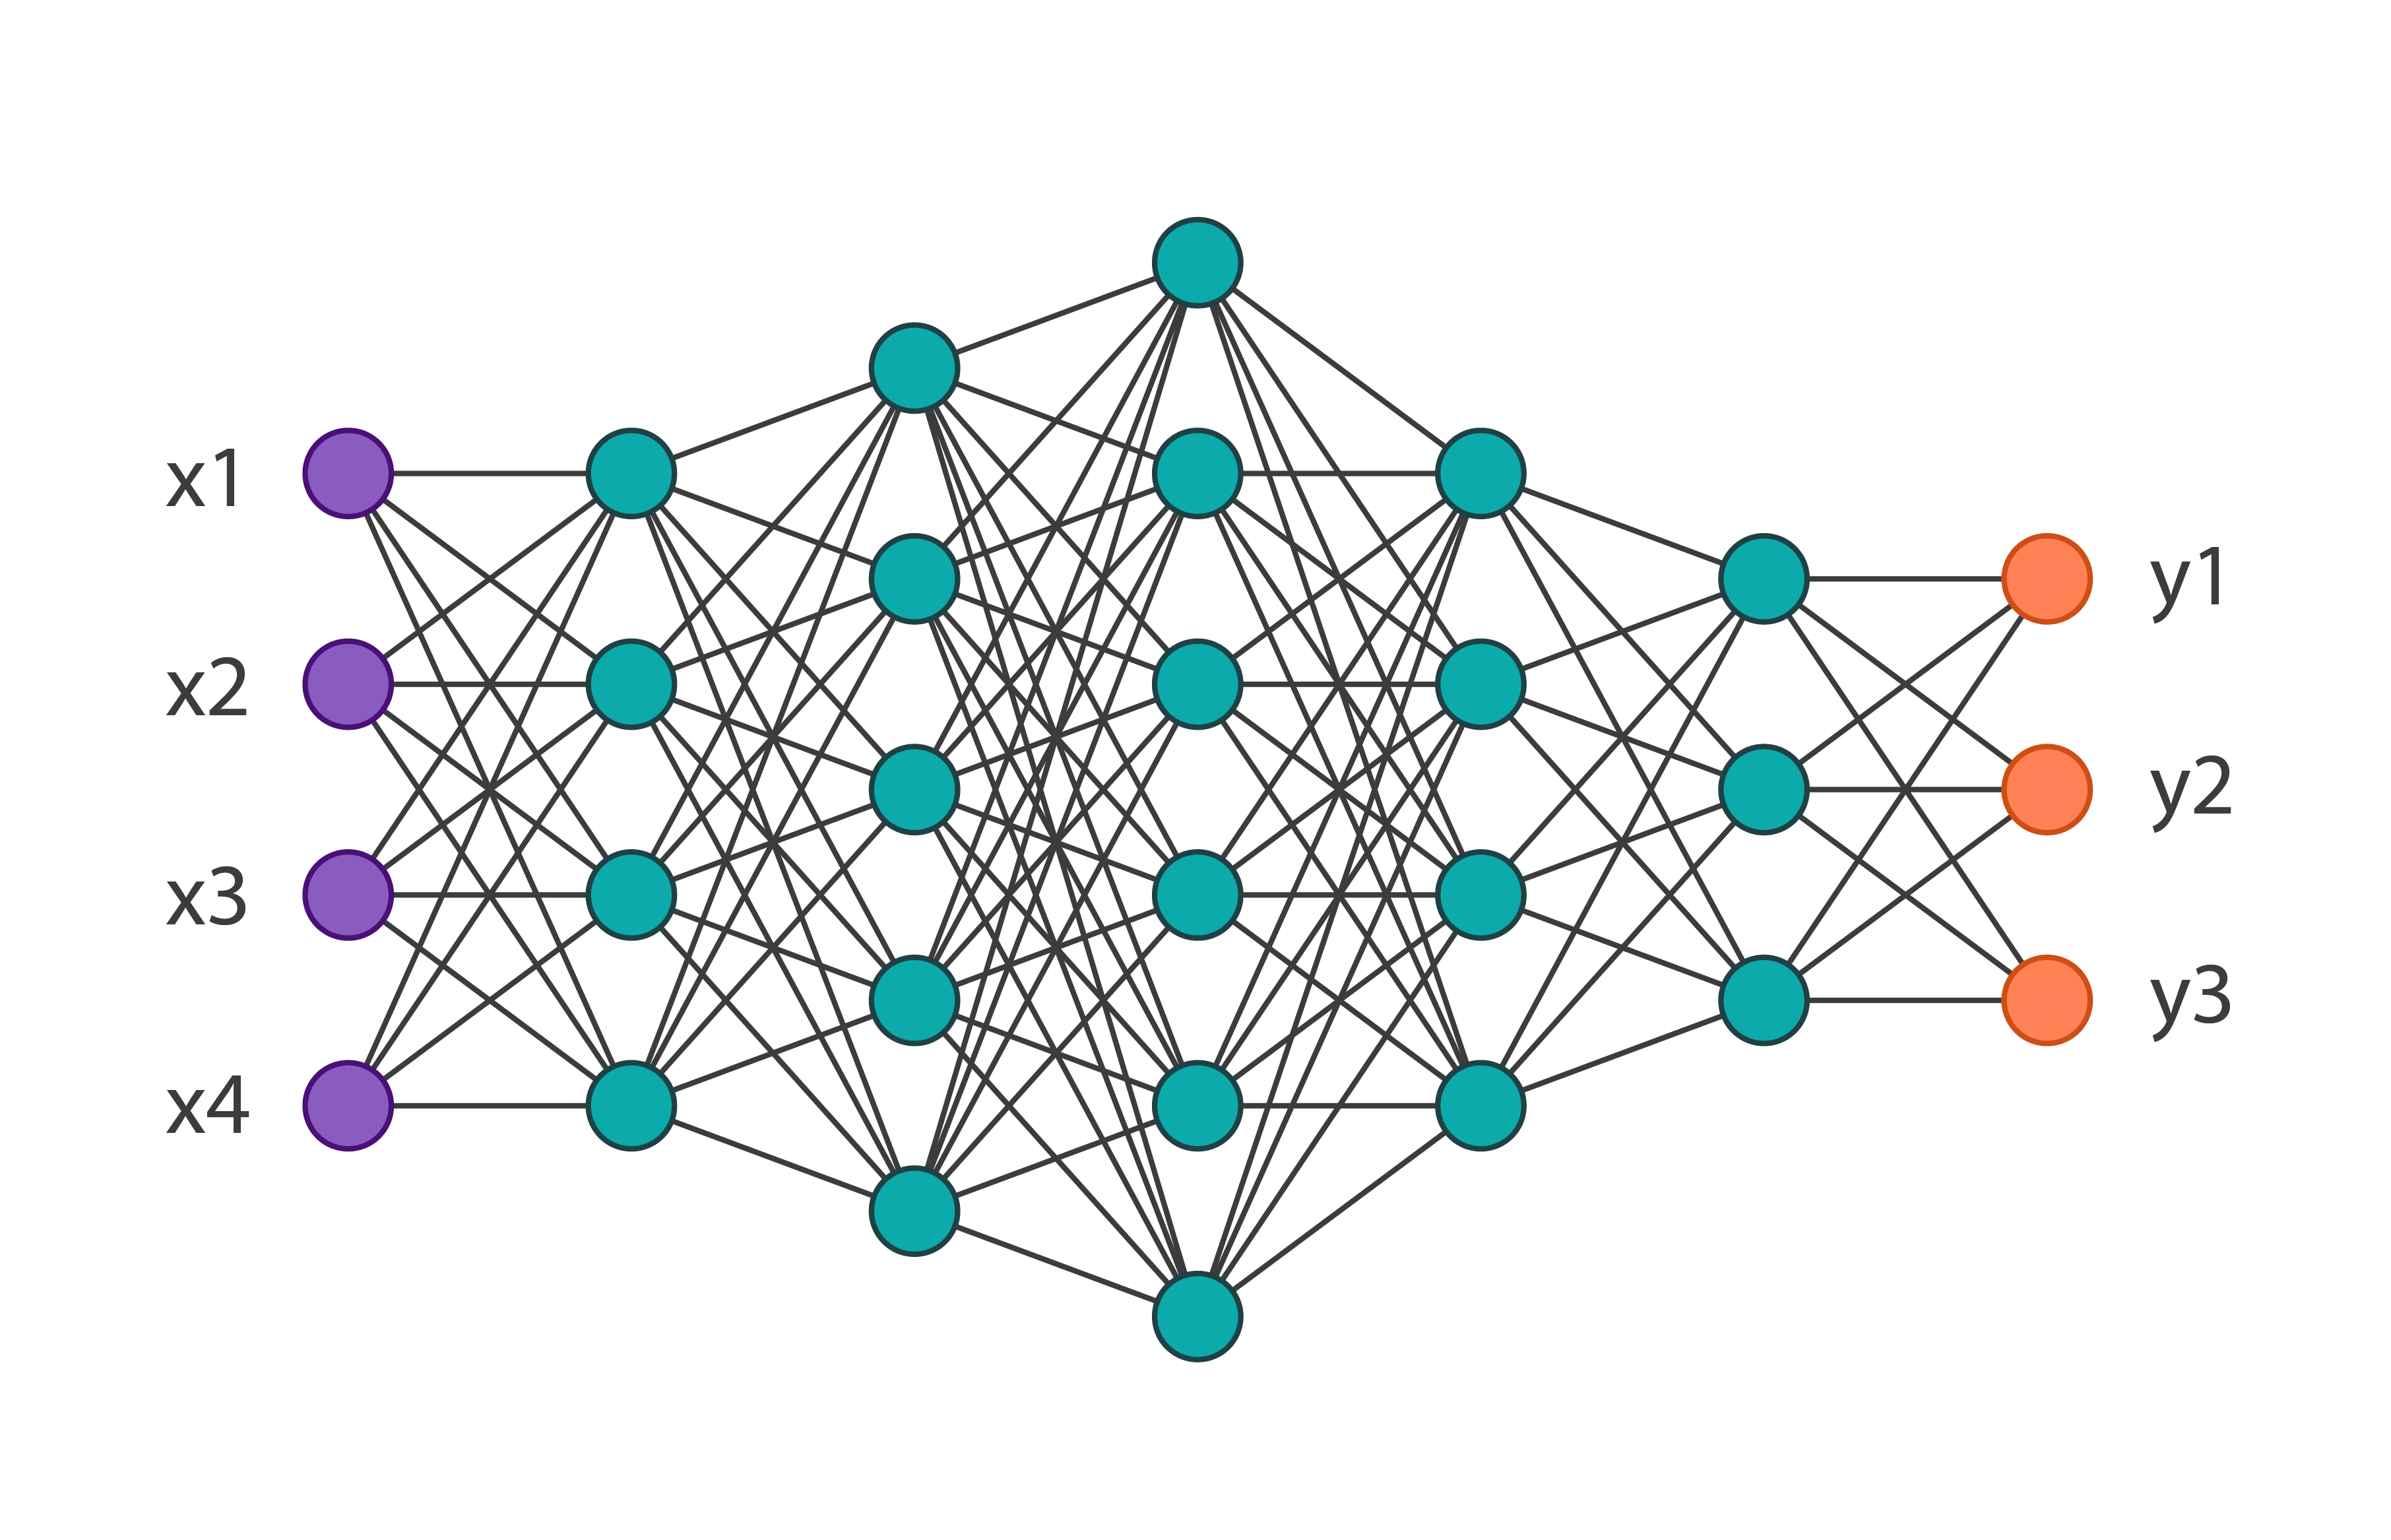

# Обучение модели CNN

In [9]:
# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [10]:
# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

### Модель

In [11]:
# Инициализация модели.
model_linear = Sequential()

# 1-й полносвязный слой.
model_linear.add(Dense(units = 32, activation = 'relu', input_shape=(180, )))
# Отключить 5% случайных нейронов в слое во время обучения. 
#model_linear.add(Dropout(0.05))

# 2-й полносвязный слой.
model_linear.add(Dense(units = 32, activation = 'relu'))
# Отключить 5% случайных нейронов в слое во время обучения. 
#model_linear.add(Dropout(0.15))

# 3-й полносвязный слой.
model_linear.add(Dense(units = 16, activation = 'relu'))
# Отключить 5% случайных нейронов в слое во время обучения. 
#model_linear.add(Dropout(0.15))

# 4-й полносвязный слой (выход модели).
model_linear.add(Dense(units = cat_num, activation = 'softmax'))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_linear.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                5792      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 7461 (29.14 KB)
Trainable params: 7461 (29.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Обучение модели

In [12]:
# Кол-во итераций обучения.
Epochs = 100

# Запустить обучение модели.
history = model_linear.fit(x = X_train, # Признаки на которых будем предсказывать цвет.
                           y = Y_train, # Правильные ответы.
                           epochs = Epochs, # Кол-во итераций обучения.
                           validation_data = (X_test, Y_test), # Валидационные данные.
                           callbacks = [learning_rate_reduction])

# Сохранить модель.
model_linear.save('model_linear.h5')

Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 1.9328 - accuracy: 0.5078 - val_loss: 1.0237 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 0s 1ms/step - loss: 0.7707 - accuracy: 0.6767 - val_loss: 0.8472 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.7122 - val_loss: 0.6540 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 0s 1ms/step - loss: 0.5626 - accuracy: 0.7589 - val_loss: 0.6679 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/100
29/29 [==============================] - 0s 1ms/step - loss: 0.5690 - accuracy: 0.7589 - val_loss: 0.5452 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 6/100
29/29 [==============================] - 0s 972us/step - loss: 0.5070 - accuracy: 0.7900 - val_loss: 0.7861 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 7/100
29/29 [==============================] - 0s 1ms/step - loss: 0

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_linear.evaluate(X_test, Y_test)[1]*100 , "%")

7/7 [==============================] - 0s 997us/step - loss: 0.1607 - accuracy: 0.9350
Accuracy of the model is -  93.50000023841858 %


# Анализ процесса обучения модели

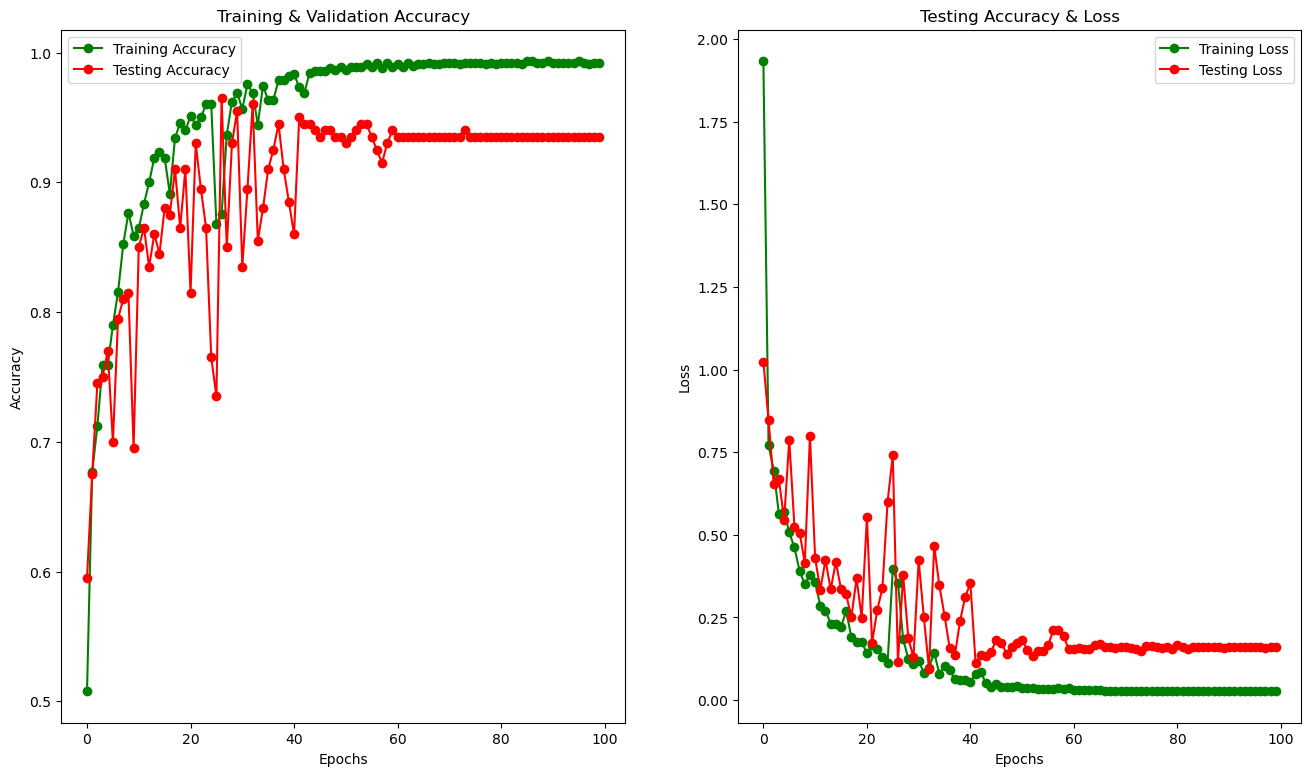

In [14]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Конвертируем модель в облегчённый формат
### Подготавливаем репрезентативную выборку

In [15]:
def representative_dataset():
    for i in range(len(X_train)):
        # Оборачиваем каждую строку в batch размером (1, 180)
        data = np.expand_dims(X_train[i], axis=0).astype(np.float32)
        yield [data]

### Конвертируем модель

In [16]:
# Платформа для машинного обучения, разработанная Google, которая предоставляет инструменты для создания, 
# обучения и развертывания моделей машинного и глубокого обучения
import tensorflow as tf

# Передаём модель в конвертер.
converter = tf.lite.TFLiteConverter.from_keras_model(model_linear)

# Передаём репрезентативную выборку в конвертер.
converter.representative_dataset = representative_dataset

# Указываем оптимизатор для модели.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Передаём набор встроенных операций, которые поддерживают 8-битные целочисленные (от -128 до 127) вычисления. 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Указываем что вход модели отныне принимает 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_input_type = tf.int8
# Указываем что выход модели отныне выдаёт 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmpa9g7e7_p\assets


INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmpa9g7e7_p\assets
C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [17]:
# Сохранить облегчённую модель.
open("model_linear.tflite", "wb").write(tflite_model)

10712

##### Команда для текстового редактора "vim" чтобы преобразовать бинарный файл в C/C++ формат, который можно использовать как массив байтов в исходном коде для ESP32.

#### xxd -i model.tflite > model.cc

### Оценим качество облегчённой модели

In [18]:
# Путь к сохранённой облегчённой модели.
tflite_model_path = "model_linear.tflite"

# Загрузка модели и выделение памяти под тензоры.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Получить входной и выходной тензоры.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Параметры для масштабирования 
input_scale, input_zero_point = input_details[0]['quantization']

# Вывести размеры входного и выходного тензора.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[  1 180]
[1 5]


In [19]:
input_scale, input_zero_point = input_details[0]['quantization']
print(input_scale)
print(input_zero_point)

0.3921568691730499
-128


In [20]:
# Список для всех предсказаний.
predictions = []

Y_test_numpy = Y_test.to_numpy()

# Предскажем классы для всей тестовой выборки.
for i in range(X_test.shape[0]):
    # Передаём данные(отмасштабируем данные [0 : 100] --> [-128 : 127]).
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(np.int8(((X_test[i]-50)/50)*127.5), axis=0))
    interpreter.invoke()
    # Получаем результат.
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    # Сохраним предсказания.
    predictions.append(tflite_model_predictions[0])
    
    print("Prediction ", i, ": ", tflite_model_predictions[0])
    print("predicted_class:",np.argmax(tflite_model_predictions, axis=1)[0])
    print("ETOO : ", Y_test_labels[i])
    print("correct_class:",np.argmax(Y_test_numpy[i]),"( ",  Y_test_labels[i], " )")
    print("------------------------------------")

Prediction  0 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  1 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  2 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  3 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  4 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  5 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------
Prediction  6 :  [ 127 -128 -128 -128 -128]
predicted_class: 0
ETOO :  empty
correct_class: 0 (  empty  )
------------------------------------

In [21]:
# Оценим качество облегчённой модели сравнив предсказания с правильными ответами.
from sklearn.metrics import accuracy_score
acc = accuracy_score(np.argmax(predictions, axis=1), np.argmax(Y_test, axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.945
